In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
from problem import get_train_data, get_test_data
X_train, y_train = get_train_data()
X_test, y_test = get_test_data()

In [3]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1000, 13551), (1000,), (500, 13551), (500,))

### Préprocessing des données


In [4]:
def preprocess_X(X):
    """
    Convertit la matrice sparse en dense
    Normalisation : chaque cellule a une somme = 1
    """
    X = X.toarray()
    return X / X.sum(axis=1)[:, np.newaxis]

# Application sur train et test
X_train_norm = preprocess_X(X_train)
X_test_norm  = preprocess_X(X_test)

# Vérification
print("Train : ", np.allclose(X_train_norm.sum(axis=1), np.ones(X_train_norm.shape[0])))
print("Test : ", np.allclose(X_test_norm.sum(axis=1),  np.ones(X_test_norm.shape[0])))
X_train_norm.shape, X_test_norm.shape


Train :  True
Test :  True


((1000, 13551), (500, 13551))

In [5]:
def preprocess_log(X_train_norm, X_test_norm):
    """
    Application du log(1 + x) pour réduire l'écart entre les valeurs
    """
    X_train_log = np.log1p(X_train_norm)
    X_test_log  = np.log1p(X_test_norm)
    return X_train_log, X_test_log

X_train_log, X_test_log = preprocess_log(X_train_norm, X_test_norm)
print("Train : min =", X_train_log.min(), ", max =", X_train_log.max())
print("Test : min =", X_test_log.min(), ", max =", X_test_log.max())

Train : min = 0.0 , max = 0.49066365
Test : min = 0.0 , max = 0.26696903


In [6]:
# On travaille à partir de X_train_log
X = X_train_log

# Calcul variance par gène
def compute_gene_variances(X):
    """
    Calcule la variance de chaque gène (chaque colonne)
    """
    return X.var(axis=0)

gene_vars = compute_gene_variances(X)

print("Nombre de gènes :", len(gene_vars))
print("Variance min:", gene_vars.min())
print("Variance max:", gene_vars.max())
print("Variance moyenne:", gene_vars.mean())
print("Variance médiane:", np.median(gene_vars))

Nombre de gènes : 13551
Variance min: 7.243719e-13
Variance max: 0.0026710336
Variance moyenne: 4.0403125e-07
Variance médiane: 1.3884672e-08


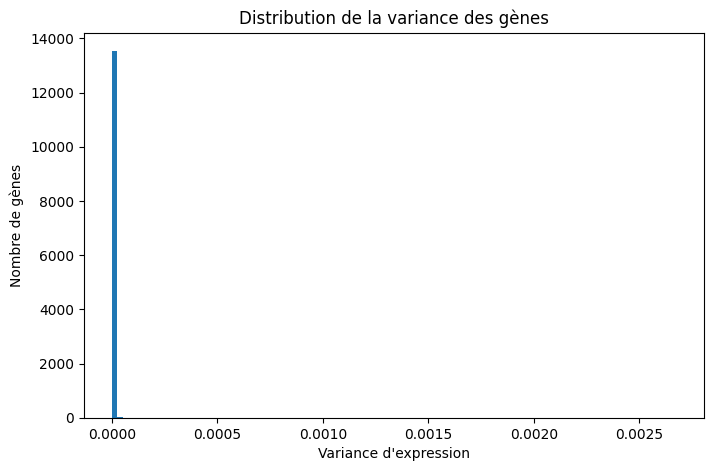

In [7]:
# 2) Histogramme de variances
plt.figure(figsize=(8,5))
plt.hist(gene_vars, bins=100)
plt.xlabel("Variance d'expression")
plt.ylabel("Nombre de gènes")
plt.title("Distribution de la variance des gènes")
plt.show()

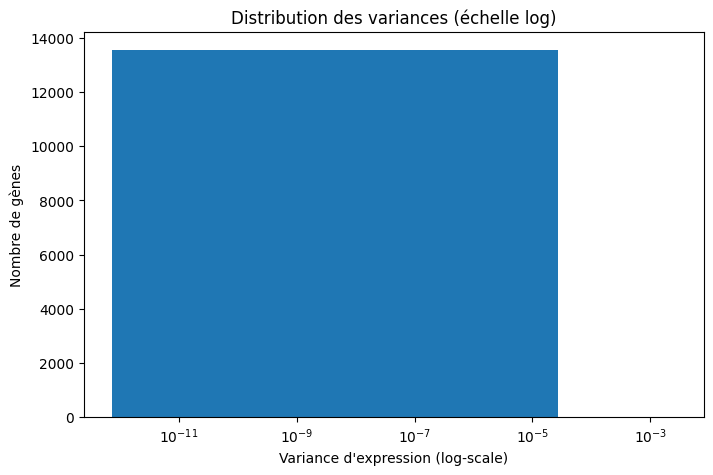

In [8]:
plt.figure(figsize=(8,5))
plt.hist(gene_vars, bins=100)
plt.xscale("log")
plt.xlabel("Variance d'expression (log-scale)")
plt.ylabel("Nombre de gènes")
plt.title("Distribution des variances (échelle log)")
plt.show()

In [9]:
# Sélection HVG : top N gènes les plus variables
def select_highly_variable_genes(gene_vars, N_HVG):
    """
    Sélectionne les indices des N_HVG gènes les plus variables
    """
    return np.argsort(gene_vars)[-N_HVG:]

N_HVG = 2000
hvg_idx = select_highly_variable_genes(gene_vars, N_HVG)

print("Indices des 10 gènes les plus variables :", hvg_idx[-10:])
print("Total HVG sélectionnés :", len(hvg_idx))

Indices des 10 gènes les plus variables : [ 4853  9825  6987  6982  6983 11841  1017  6981  4854  6340]
Total HVG sélectionnés : 2000


In [10]:
# Extraire la matrice réduite
X_train_hvg = X[:, hvg_idx]
X_test_hvg  = X_test_log[:, hvg_idx]

print("Matrice train HVG :", X_train_hvg.shape)
print("Matrice test  HVG :", X_test_hvg.shape)

Matrice train HVG : (1000, 2000)
Matrice test  HVG : (500, 2000)


In [11]:
# Transformer les labels textes en catégories numériques
labels_unique = np.unique(y_train)
label_to_int = {lab: i for i, lab in enumerate(labels_unique)}
print(label_to_int)

y_train_int = np.array([label_to_int[l] for l in y_train])

{'Cancer_cells': 0, 'NK_cells': 1, 'T_cells_CD4+': 2, 'T_cells_CD8+': 3}


Shape PCA : (1000, 2)


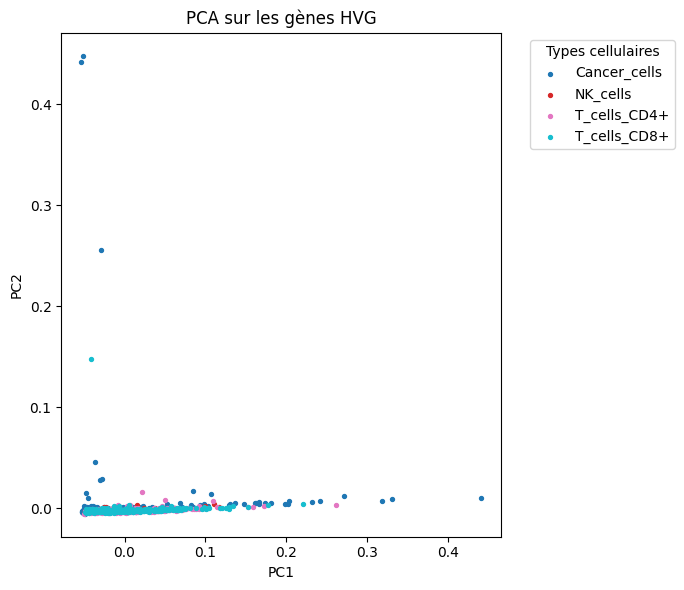

In [14]:
from sklearn.decomposition import PCA

# PCA à partir de X_train_hvg
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_hvg)

print("Shape PCA :", X_pca.shape)

# Affichage
plt.figure(figsize=(7,6))

classes = np.unique(y_train)
colors = plt.cm.tab10(np.linspace(0, 1, len(classes)))

for i, cls in enumerate(classes):
    indices = np.where(y_train == cls)[0]
    
    plt.scatter(
        X_pca[indices, 0],
        X_pca[indices, 1],
        s=8,
        color=colors[i],
        label=cls
    )

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA sur les gènes HVG")
plt.legend(title="Types cellulaires", bbox_to_anchor=(1.05,1), loc="upper left")
plt.tight_layout()
plt.show()